**import libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tensorflow.keras.utils import plot_model
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Bidirectional, GlobalMaxPooling1D, Flatten

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

### **Read Dataset**

In [8]:
!gdown --id 14Bm-AxTFvgtMAcmq7g0Jra4uZvt1d_aN

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14Bm-AxTFvgtMAcmq7g0Jra4uZvt1d_aN
To: /content/review_50_clothing_product.csv
100% 22.8M/22.8M [00:00<00:00, 250MB/s]


In [9]:
df = pd.read_csv('/content/review_50_clothing_product.csv')

In [10]:
df.head()

,Unnamed: 0,stars,title,body
0,0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...
1,1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...
2,2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...
3,3,5.0 out of 5 stars,OMG I love these pants.,They feel so good and smooth. Great if you are...
4,4,4.0 out of 5 stars,"Nice, but large","These are comfortable, but as others have ment..."


In [11]:
df.shape

(114451, 4)

**Prepare Dataset**

In [12]:
df['star'] = df['stars'].apply(lambda x: str(x).split()[0]).astype(float)

In [13]:
df.head(3)

,Unnamed: 0,stars,title,body,star
0,0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0
1,1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0
2,2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0


In [14]:
df.shape

(114451, 5)

In [15]:
#remove 3 stars reviews
indexAge = df[(df['star'] == 3)].index
df.drop(indexAge, inplace=True)

In [16]:
df.shape

(107460, 5)

In [17]:
df['sentiment'] = df['star'].apply(lambda x: 1 if x >= 3 else 0)

In [18]:
df.head(3)

,Unnamed: 0,stars,title,body,star,sentiment
0,0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0,1
1,1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0,1
2,2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0,1


In [19]:
df['sentiment'].unique()

array([1, 0])

In [20]:
df['sentiment'].value_counts()

1    64680
0    42780
Name: sentiment, dtype: int64

In [21]:
positive = df[(df['sentiment'] == 1)]
negative = df[(df['sentiment'] == 0)]

In [22]:
print(positive.shape)
print(negative.shape)

(64680, 6)
(42780, 6)


In [23]:
positive_sample = positive.sample(n=60_000, replace=True, random_state=50)
negative_sample = negative.sample(n=40_000, replace=True, random_state=50)

In [24]:
data = pd.concat([positive_sample, negative_sample], axis=0)

In [25]:
data.shape

(100000, 6)

In [26]:
data.tail()

,Unnamed: 0,stars,title,body,star,sentiment
106130,5100,2.0 out of 5 stars,Question Durability,Fits a little tight however after 1 wash on no...,2.0,0
45334,45334,1.0 out of 5 stars,Jeans,Didn't like the length because whenever you si...,1.0,0
84189,84189,1.0 out of 5 stars,The front is way too tight,I have owned two pair of these in the past and...,1.0,0
108887,7857,1.0 out of 5 stars,Way too large,"This is like a 40"" waist and baggy.Not gonna b...",1.0,0
96315,2743,2.0 out of 5 stars,Defected stitching,Stitching came apart in several areas of the h...,2.0,0


### **Preprocessing**

In [27]:
bodies = data['body'].values
titles = data['title'].values
y = data['sentiment'].values

In [28]:
print(bodies.shape)
print(titles.shape)
print(y.shape)

(100000,)
(100000,)
(100000,)


In [29]:
sentences = [(str(t)+' '+str(b)) for t,b in zip(titles,bodies)]

In [30]:
sentences[0]

'Love this shirt I love this shirt. Size was perfect!'

In [31]:
sentences_without_punctuation = [s for s in sentences if s not in string.punctuation]

In [32]:
sentences_without_punctuation[0]

'Love this shirt I love this shirt. Size was perfect!'

In [33]:
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenize = [tokenizer.tokenize(s.lower()) for s in sentences_without_punctuation]

In [34]:
sentences_tokenize[0]

['love',
 'this',
 'shirt',
 'i',
 'love',
 'this',
 'shirt',
 'size',
 'was',
 'perfect']

In [35]:
stop_words = stopwords.words("english")
stop_words.extend([':)', '.', ',', '!', '?', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '18', 'also', 'ls', 'xl', '2xl', 'u', 'w', 'c', 'ua', '3rd', '20', '30', '40', '50', '60', '70', '80', '90', '100', 'è', 'et', 'zu', 'le', '2nd', 'ago'])

In [36]:
len(stop_words)

221

In [37]:
sentences_tokenize_filtered = [[w for w in sentence if w not in stop_words] for sentence in sentences_tokenize]

In [38]:
sentences_tokenize_filtered[0]

['love', 'shirt', 'love', 'shirt', 'size', 'perfect']

In [39]:
porter_stemmer = PorterStemmer()
sentences_tokenize_filtered_stem = [[porter_stemmer.stem(w) for w in sentence] for sentence in sentences_tokenize_filtered]

In [40]:
lem = WordNetLemmatizer()
sentences_tokenize_filtered_lem = [[lem.lemmatize(w) for w in sentence] for sentence in sentences_tokenize_filtered_stem]

In [41]:
sentences_tokenize_filtered_lem[0]

['love', 'shirt', 'love', 'shirt', 'size', 'perfect']

In [42]:
corpus = []
for sentence in sentences_tokenize_filtered_lem:
  s = ''
  s = ' '.join(sentence)
  corpus.append(s) 

In [43]:
corpus[0]

'love shirt love shirt size perfect'

**keras Tokenizer**

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [43]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [44]:
vocab_size = len(tokenizer.word_index) + 1

In [45]:
vocab_size

23833

In [46]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [47]:
data_to_sequences = tokenizer.texts_to_sequences(corpus)

In [48]:
maxlen = max_length(data_to_sequences)
maxlen

517

In [49]:
data_to_sequences[0]

[6, 14, 6, 14, 2, 13]

In [50]:
pad_data_to_sequences = pad_sequences(data_to_sequences, padding='post', maxlen=100)

In [51]:
pad_data_to_sequences[0]

array([ 6, 14,  6, 14,  2, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [52]:
print(pad_data_to_sequences.shape)
print(y.shape)

(100000, 100)
(100000,)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(pad_data_to_sequences, y, test_size=0.3, shuffle=True, random_state=50)

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 100)
(30000, 100)
(70000,)
(30000,)


## **Neural Networks**

### **Support Vector Machine -> (SVM)**

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

In [44]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [55]:
XTrain, XTest, ytrain, ytest = train_test_split(corpus, y, test_size=0.3, shuffle=True, random_state=50)

In [56]:
train_vectors = vectorizer.fit_transform(XTrain)
test_vectors = vectorizer.transform(XTest)

In [57]:
train_vectors[0]

<1x6790 sparse matrix of type '<class 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [58]:
classifier_linear = svm.SVC(kernel='linear')

In [59]:
classifier_linear.fit(train_vectors, ytrain)

SVC(kernel='linear')

In [60]:
prediction_linear = classifier_linear.predict(test_vectors)

In [61]:
print(prediction_linear)

[1 1 0 ... 1 1 1]


In [62]:
report = classification_report(ytest, prediction_linear, output_dict=True)

In [64]:
report

{'0': {'precision': 0.9022042057258678,
  'recall': 0.8887687188019967,
  'f1-score': 0.8954360672226647,
  'support': 12020},
 '1': {'precision': 0.9263725976100006,
  'recall': 0.93559510567297,
  'f1-score': 0.9309610116494647,
  'support': 17980},
 'accuracy': 0.9168333333333333,
 'macro avg': {'precision': 0.9142884016679342,
  'recall': 0.9121819122374833,
  'f1-score': 0.9131985394360647,
  'support': 30000},
 'weighted avg': {'precision': 0.9166891285950913,
  'recall': 0.9168333333333333,
  'f1-score': 0.9167273505824601,
  'support': 30000}}

### **Naive Bayes -> (NB)**

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [45]:
XTrain, XTest, ytrain, ytest = train_test_split(corpus, y, test_size=0.3, shuffle=True, random_state=50)

In [49]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [50]:
train_vectors = vectorizer.fit_transform(XTrain)
test_vectors = vectorizer.transform(XTest)

In [51]:
model = MultinomialNB()
model.fit(train_vectors, ytrain)

MultinomialNB()

In [52]:
model.score(test_vectors, ytest)

0.8830666666666667

In [53]:
y_pred = model.predict(test_vectors)

In [54]:
report = classification_report(ytest, y_pred, output_dict=True)

In [55]:
report

{'0': {'precision': 0.9149765990639626,
  'recall': 0.7806988352745424,
  'f1-score': 0.8425210989405638,
  'support': 12020},
 '1': {'precision': 0.8664910858995137,
  'recall': 0.9515016685205784,
  'f1-score': 0.9070088007634397,
  'support': 17980},
 'accuracy': 0.8830666666666667,
 'macro avg': {'precision': 0.8907338424817381,
  'recall': 0.8661002518975605,
  'f1-score': 0.8747649498520018,
  'support': 30000},
 'weighted avg': {'precision': 0.8859176148407363,
  'recall': 0.8830666666666667,
  'f1-score': 0.8811707282330742,
  'support': 30000}}

### **Logistic Regresion**

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [46]:
XTrain, XTest, ytrain, ytest = train_test_split(corpus, y, test_size=0.3, shuffle=True, random_state=50)

In [47]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 8,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [48]:
train_vectors = vectorizer.fit_transform(XTrain)
test_vectors = vectorizer.transform(XTest)

In [55]:
log_model = LogisticRegression()

In [56]:
log_model.fit(train_vectors, ytrain)

LogisticRegression()

In [57]:
log_model.score(test_vectors, ytest)

0.9129

In [58]:
y_pred = log_model.predict(test_vectors)

In [59]:
report = classification_report(ytest, y_pred, output_dict=True)

In [60]:
report

{'0': {'precision': 0.8944234800838574,
  'recall': 0.8873544093178036,
  'f1-score': 0.8908749216955523,
  'support': 12020},
 '1': {'precision': 0.9250899031811894,
  'recall': 0.9299777530589544,
  'f1-score': 0.9275273887116904,
  'support': 17980},
 'accuracy': 0.9129,
 'macro avg': {'precision': 0.9097566916325235,
  'recall': 0.908666081188379,
  'f1-score': 0.9092011552036213,
  'support': 30000},
 'weighted avg': {'precision': 0.9128028896601916,
  'recall': 0.9129,
  'f1-score': 0.9128419669272243,
  'support': 30000}}

### **CNN Model**

In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=100))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(64, 4, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 100, 50)           1191650   
                                                                 
 batch_normalization_15 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 dropout_104 (Dropout)       (None, 100, 50)           0         
                                                                 
 conv1d_69 (Conv1D)          (None, 97, 64)            12864     
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 48, 64)           0         
 g1D)                                                            
                                                                 
 dropout_105 (Dropout)       (None, 48, 64)          

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=512)

Epoch 1/8
137/137 [==============================] - 4s 18ms/step - loss: 0.5950 - accuracy: 0.6821 - val_loss: 0.6464 - val_accuracy: 0.6060
Epoch 2/8
137/137 [==============================] - 2s 17ms/step - loss: 0.2979 - accuracy: 0.8870 - val_loss: 0.5766 - val_accuracy: 0.7957
Epoch 3/8
137/137 [==============================] - 3s 24ms/step - loss: 0.2461 - accuracy: 0.9090 - val_loss: 0.4756 - val_accuracy: 0.8937
Epoch 4/8
137/137 [==============================] - 4s 27ms/step - loss: 0.2203 - accuracy: 0.9193 - val_loss: 0.3547 - val_accuracy: 0.9120
Epoch 5/8
137/137 [==============================] - 4s 30ms/step - loss: 0.2017 - accuracy: 0.9268 - val_loss: 0.2675 - val_accuracy: 0.9189
Epoch 6/8
137/137 [==============================] - 4s 26ms/step - loss: 0.1844 - accuracy: 0.9335 - val_loss: 0.2357 - val_accuracy: 0.9225
Epoch 7/8
137/137 [==============================] - 4s 29ms/step - loss: 0.1734 - accuracy: 0.9368 - val_loss: 0.2260 - val_accuracy: 0.9231
Epoch 

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

938/938 [==============================] - 6s 6ms/step - loss: 0.2137 - accuracy: 0.9245
Accuracy: 92.45%


In [ ]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

938/938 [==============================] - 3s 3ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.93      0.88      0.90     12020
Positive Reviews       0.92      0.96      0.94     17980

        accuracy                           0.92     30000
       macro avg       0.93      0.92      0.92     30000
    weighted avg       0.92      0.92      0.92     30000



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.9257826501981167, 0.9164817998922818, 0.9205412058859223, None)
(0.9244666666666667, 0.9244666666666667, 0.9244666666666667, None)
(0.9247193012491685, 0.9244666666666667, 0.9240498660918666, None)


### **LSTM Model**

In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=100))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 100, 50)           1191650   
                                                                 
 batch_normalization_20 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 dropout_127 (Dropout)       (None, 100, 50)           0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 100, 512)         628736    
 onal)                                                           
                                                                 
 global_max_pooling1d_29 (Gl  (None, 512)              0         
 obalMaxPooling1D)                                               
                                                     

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=512)

Epoch 1/5
137/137 [==============================] - 20s 120ms/step - loss: 0.3110 - accuracy: 0.8677 - val_loss: 0.5787 - val_accuracy: 0.6345
Epoch 2/5
137/137 [==============================] - 15s 113ms/step - loss: 0.2009 - accuracy: 0.9237 - val_loss: 0.4610 - val_accuracy: 0.8272
Epoch 3/5
137/137 [==============================] - 15s 109ms/step - loss: 0.1737 - accuracy: 0.9350 - val_loss: 0.2820 - val_accuracy: 0.9042
Epoch 4/5
137/137 [==============================] - 15s 108ms/step - loss: 0.1530 - accuracy: 0.9432 - val_loss: 0.2150 - val_accuracy: 0.9173
Epoch 5/5
137/137 [==============================] - 15s 108ms/step - loss: 0.1392 - accuracy: 0.9480 - val_loss: 0.1943 - val_accuracy: 0.9286


In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

938/938 [==============================] - 7s 7ms/step - loss: 0.1943 - accuracy: 0.9286
Accuracy: 92.86%


In [ ]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

938/938 [==============================] - 7s 6ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.94      0.88      0.91     12020
Positive Reviews       0.92      0.96      0.94     17980

        accuracy                           0.93     30000
       macro avg       0.93      0.92      0.92     30000
    weighted avg       0.93      0.93      0.93     30000



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.931051954543803, 0.9200541737075212, 0.9247640467737495, None)
(0.9286, 0.9286, 0.9286, None)
(0.9291260651024396, 0.9286, 0.9281390513837956, None)


### **CNN-LSTM Model**

In [ ]:
embedding_dim = 50

i = Input(shape=(100,))
x = Embedding(vocab_size, embedding_dim, input_length=100)(i)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(64, 4, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 2, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(i, x)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_31 (Embedding)    (None, 100, 50)           1191650   
                                                                 
 batch_normalization_19 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 dropout_122 (Dropout)       (None, 100, 50)           0         
                                                                 
 conv1d_78 (Conv1D)          (None, 100, 64)           12864     
                                                                 
 dropout_123 (Dropout)       (None, 100, 64)           0         
                                                          

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=11, batch_size=512)

Epoch 1/11
137/137 [==============================] - 10s 26ms/step - loss: 0.3945 - accuracy: 0.8190 - val_loss: 0.6103 - val_accuracy: 0.8729
Epoch 2/11
137/137 [==============================] - 3s 20ms/step - loss: 0.2291 - accuracy: 0.9162 - val_loss: 0.5168 - val_accuracy: 0.9002
Epoch 3/11
137/137 [==============================] - 3s 20ms/step - loss: 0.2023 - accuracy: 0.9271 - val_loss: 0.4105 - val_accuracy: 0.9083
Epoch 4/11
137/137 [==============================] - 3s 20ms/step - loss: 0.1834 - accuracy: 0.9345 - val_loss: 0.2399 - val_accuracy: 0.9234
Epoch 5/11
137/137 [==============================] - 3s 20ms/step - loss: 0.1654 - accuracy: 0.9412 - val_loss: 0.2099 - val_accuracy: 0.9259
Epoch 6/11
137/137 [==============================] - 3s 20ms/step - loss: 0.1577 - accuracy: 0.9439 - val_loss: 0.1974 - val_accuracy: 0.9268
Epoch 7/11
137/137 [==============================] - 3s 20ms/step - loss: 0.1449 - accuracy: 0.9487 - val_loss: 0.1936 - val_accuracy: 0.928

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

938/938 [==============================] - 4s 4ms/step - loss: 0.1916 - accuracy: 0.9319
Accuracy: 93.19%


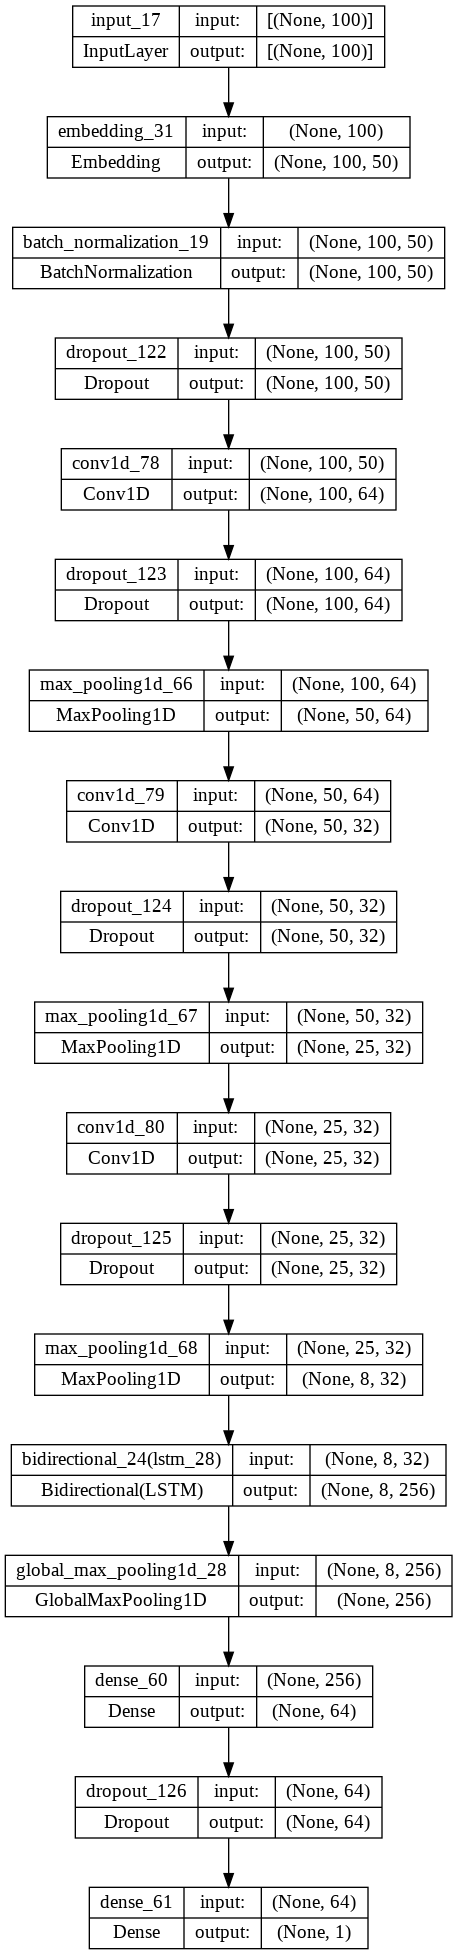

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

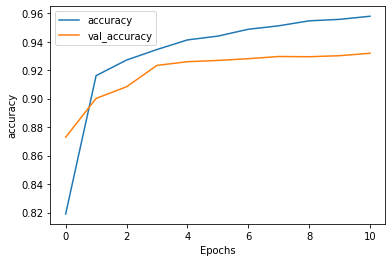

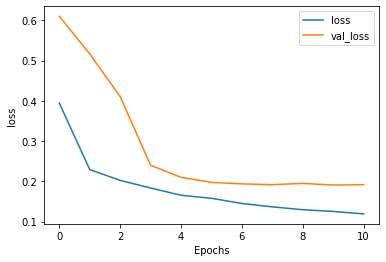

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

938/938 [==============================] - 4s 3ms/step


In [ ]:
y_true

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.93      0.90      0.91     12020
Positive Reviews       0.93      0.96      0.94     17980

        accuracy                           0.93     30000
       macro avg       0.93      0.93      0.93     30000
    weighted avg       0.93      0.93      0.93     30000



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.9318377652815377, 0.9258542954919405, 0.9285902711972407, None)
(0.9318666666666666, 0.9318666666666666, 0.9318666666666666, None)
(0.931862758353994, 0.9318666666666666, 0.9316290693606049, None)


In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm

array([[10765,  1255],
       [  789, 17191]])

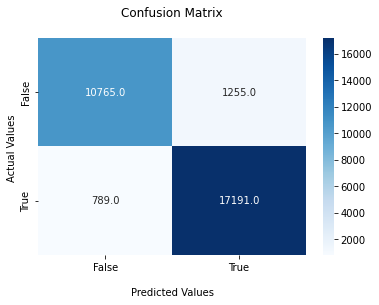

In [ ]:
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.1f')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

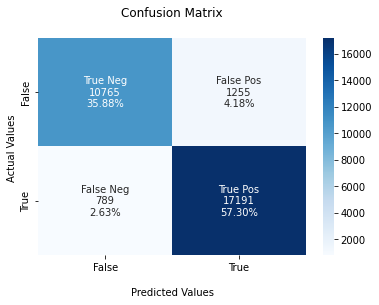

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [ ]:
def prediction(sentence):
  data = tokenizer.texts_to_sequences([sentence])
  data_pad_sequence = pad_sequences(data, maxlen=50)
  perdiction = model.predict(data_pad_sequence)
  print(perdiction[0])
  if perdiction[0][0] > 0.5:
    return "positive"
  else: 
    return "negative" 